# 07. PyTorch Experiment Tracking Exercise Template

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [8]:
import torch
import torchvision

In [9]:
# Make sure we have a GPU
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [10]:
# Get regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine

In [11]:
# Set seeds
def set_seeds(seed: int=37):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 37.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for mps torch operations (ones that happen on the GPU)
    torch.mps.manual_seed(seed)

In [12]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [13]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [14]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs/2025-06-23/test_experiment_name/this_is_the_model_name/add_a_little_extra_if_you_want...


### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [15]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [16]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [17]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders 

In [18]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In [19]:
weights_b3 = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)

In [20]:
summary(model=model_b3, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    1,080                True
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    80                   True
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 24, 112,

In [21]:
def create_effnetb2(out_features=len(class_names)):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    dropout = 0.3
    in_features=1408

    # Freeze the base model layers
    for param in model.features.parameters():
      param.requires_grad=False

    # Set the seeds
    set_seeds() 

    # Update the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, 
                  out_features=out_features)
    ).to(device) 

    # Set the model name
    model.name = "effnetb2"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model

def create_effnetb3(out_features=len(class_names)):
    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
    model = torchvision.models.efficientnet_b3(weights=weights).to(device)
    dropout = 0.2
    in_features=1536
    
    # Freeze the base model layers
    for param in model.features.parameters():
      param.requires_grad=False

    # Set the seeds
    set_seeds() 

    # Update the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, 
                  out_features=out_features)
    ).to(device) 

    # Set the model name
    model.name = "effnetb3"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model

In [22]:
# 1. create epochs list
num_epochs = [5, 10]

# 2. create model list
models = ["effnetb2", "effnetb3"]

# 3. create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [23]:
from going_modular.utils import save_model
from going_modular.engine import train

set_seeds()

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            # create information print out
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs:{epochs}")

            if model_name == "effnetb2":
                model = create_effnetb2()
            else:
                model = create_effnetb3()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            writer = create_writer(experiment_name=dataloader_name,
                                   model_name=model_name, extra=f"{epochs}_epochs")
            print(type(writer))
            train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                  loss_fn=loss_fn, optimizer=optimizer, epochs=epochs, device=device, writer=writer)

            save_filepath = f"07_exercise_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir="models", model_name=save_filepath)
            print("-"*50+"\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:5
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_10_percent/effnetb2/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0566 | train_acc: 0.3594 | test_loss: 0.9663 | test_acc: 0.6922


 20%|██        | 1/5 [00:04<00:17,  4.47s/it]

Epoch: 2 | train_loss: 0.8658 | train_acc: 0.7383 | test_loss: 0.8066 | test_acc: 0.8239


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

Epoch: 3 | train_loss: 0.8455 | train_acc: 0.6797 | test_loss: 0.7573 | test_acc: 0.8551


 60%|██████    | 3/5 [00:10<00:06,  3.36s/it]

Epoch: 4 | train_loss: 0.6883 | train_acc: 0.7695 | test_loss: 0.7665 | test_acc: 0.7841


 80%|████████  | 4/5 [00:13<00:03,  3.21s/it]

Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7578 | test_loss: 0.7689 | test_acc: 0.7225


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


[INFO] Saving model to: models/07_exercise_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb3
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:5
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_10_percent/effnetb3/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0677 | train_acc: 0.3477 | test_loss: 0.9960 | test_acc: 0.6297


 20%|██        | 1/5 [00:04<00:19,  4.95s/it]

Epoch: 2 | train_loss: 0.9349 | train_acc: 0.5977 | test_loss: 0.8262 | test_acc: 0.8750


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

Epoch: 3 | train_loss: 0.7829 | train_acc: 0.8438 | test_loss: 0.7980 | test_acc: 0.8144


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

Epoch: 4 | train_loss: 0.6929 | train_acc: 0.8594 | test_loss: 0.7907 | test_acc: 0.7235


 80%|████████  | 4/5 [00:15<00:03,  3.61s/it]

Epoch: 5 | train_loss: 0.7219 | train_acc: 0.7305 | test_loss: 0.7229 | test_acc: 0.7538


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_10_percent/effnetb2/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0566 | train_acc: 0.3594 | test_loss: 0.9663 | test_acc: 0.6922


 10%|█         | 1/10 [00:03<00:28,  3.13s/it]

Epoch: 2 | train_loss: 0.8658 | train_acc: 0.7383 | test_loss: 0.8066 | test_acc: 0.8239


 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

Epoch: 3 | train_loss: 0.8455 | train_acc: 0.6797 | test_loss: 0.7573 | test_acc: 0.8551


 30%|███       | 3/10 [00:09<00:21,  3.06s/it]

Epoch: 4 | train_loss: 0.6883 | train_acc: 0.7695 | test_loss: 0.7665 | test_acc: 0.7841


 40%|████      | 4/10 [00:12<00:18,  3.05s/it]

Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7578 | test_loss: 0.7689 | test_acc: 0.7225


 50%|█████     | 5/10 [00:15<00:15,  3.06s/it]

Epoch: 6 | train_loss: 0.5874 | train_acc: 0.8906 | test_loss: 0.6968 | test_acc: 0.8466


 60%|██████    | 6/10 [00:18<00:12,  3.08s/it]

Epoch: 7 | train_loss: 0.6047 | train_acc: 0.7734 | test_loss: 0.6879 | test_acc: 0.8466


 70%|███████   | 7/10 [00:21<00:09,  3.06s/it]

Epoch: 8 | train_loss: 0.5076 | train_acc: 0.9062 | test_loss: 0.5854 | test_acc: 0.8561


 80%|████████  | 8/10 [00:24<00:06,  3.03s/it]

Epoch: 9 | train_loss: 0.5786 | train_acc: 0.7539 | test_loss: 0.5407 | test_acc: 0.8655


 90%|█████████ | 9/10 [00:27<00:03,  3.03s/it]

Epoch: 10 | train_loss: 0.5297 | train_acc: 0.8008 | test_loss: 0.5563 | test_acc: 0.8466


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


[INFO] Saving model to: models/07_exercise_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb3
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:10
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_10_percent/effnetb3/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0677 | train_acc: 0.3477 | test_loss: 0.9960 | test_acc: 0.6297


 10%|█         | 1/10 [00:03<00:31,  3.51s/it]

Epoch: 2 | train_loss: 0.9349 | train_acc: 0.5977 | test_loss: 0.8262 | test_acc: 0.8750


 20%|██        | 2/10 [00:06<00:27,  3.43s/it]

Epoch: 3 | train_loss: 0.7829 | train_acc: 0.8438 | test_loss: 0.7980 | test_acc: 0.8144


 30%|███       | 3/10 [00:10<00:23,  3.40s/it]

Epoch: 4 | train_loss: 0.6929 | train_acc: 0.8594 | test_loss: 0.7907 | test_acc: 0.7235


 40%|████      | 4/10 [00:13<00:20,  3.38s/it]

Epoch: 5 | train_loss: 0.7219 | train_acc: 0.7305 | test_loss: 0.7229 | test_acc: 0.7538


 50%|█████     | 5/10 [00:16<00:16,  3.37s/it]

Epoch: 6 | train_loss: 0.6203 | train_acc: 0.9023 | test_loss: 0.6684 | test_acc: 0.7642


 60%|██████    | 6/10 [00:20<00:13,  3.42s/it]

Epoch: 7 | train_loss: 0.6523 | train_acc: 0.7578 | test_loss: 0.6517 | test_acc: 0.7945


 70%|███████   | 7/10 [00:23<00:10,  3.41s/it]

Epoch: 8 | train_loss: 0.5293 | train_acc: 0.8789 | test_loss: 0.5558 | test_acc: 0.8968


 80%|████████  | 8/10 [00:27<00:06,  3.40s/it]

Epoch: 9 | train_loss: 0.4822 | train_acc: 0.8906 | test_loss: 0.5458 | test_acc: 0.9062


 90%|█████████ | 9/10 [00:30<00:03,  3.39s/it]

Epoch: 10 | train_loss: 0.5976 | train_acc: 0.7383 | test_loss: 0.5181 | test_acc: 0.8655


100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:5
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent/effnetb2/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9866 | train_acc: 0.5292 | test_loss: 0.8185 | test_acc: 0.8248


 20%|██        | 1/5 [00:04<00:17,  4.48s/it]

Epoch: 2 | train_loss: 0.7674 | train_acc: 0.7167 | test_loss: 0.6727 | test_acc: 0.8561


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

Epoch: 3 | train_loss: 0.6088 | train_acc: 0.8354 | test_loss: 0.6421 | test_acc: 0.8153


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

Epoch: 4 | train_loss: 0.4896 | train_acc: 0.8979 | test_loss: 0.5271 | test_acc: 0.8873


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Epoch: 5 | train_loss: 0.4712 | train_acc: 0.8771 | test_loss: 0.5021 | test_acc: 0.8769


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


[INFO] Saving model to: models/07_exercise_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:5
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent/effnetb3/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9480 | train_acc: 0.6625 | test_loss: 0.8406 | test_acc: 0.7737


 20%|██        | 1/5 [00:04<00:19,  4.90s/it]

Epoch: 2 | train_loss: 0.7340 | train_acc: 0.7562 | test_loss: 0.6667 | test_acc: 0.8258


 40%|████      | 2/5 [00:09<00:13,  4.61s/it]

Epoch: 3 | train_loss: 0.5812 | train_acc: 0.8625 | test_loss: 0.5535 | test_acc: 0.8864


 60%|██████    | 3/5 [00:13<00:09,  4.53s/it]

Epoch: 4 | train_loss: 0.5482 | train_acc: 0.8521 | test_loss: 0.5497 | test_acc: 0.8153


 80%|████████  | 4/5 [00:18<00:04,  4.48s/it]

Epoch: 5 | train_loss: 0.4338 | train_acc: 0.8896 | test_loss: 0.4747 | test_acc: 0.8362


100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent/effnetb2/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9866 | train_acc: 0.5292 | test_loss: 0.8185 | test_acc: 0.8248


 10%|█         | 1/10 [00:04<00:36,  4.00s/it]

Epoch: 2 | train_loss: 0.7674 | train_acc: 0.7167 | test_loss: 0.6727 | test_acc: 0.8561


 20%|██        | 2/10 [00:07<00:31,  3.99s/it]

Epoch: 3 | train_loss: 0.6088 | train_acc: 0.8354 | test_loss: 0.6421 | test_acc: 0.8153


 30%|███       | 3/10 [00:11<00:27,  3.98s/it]

Epoch: 4 | train_loss: 0.4896 | train_acc: 0.8979 | test_loss: 0.5271 | test_acc: 0.8873


 40%|████      | 4/10 [00:15<00:23,  4.00s/it]

Epoch: 5 | train_loss: 0.4712 | train_acc: 0.8771 | test_loss: 0.5021 | test_acc: 0.8769


 50%|█████     | 5/10 [00:19<00:19,  3.99s/it]

Epoch: 6 | train_loss: 0.3936 | train_acc: 0.8958 | test_loss: 0.5078 | test_acc: 0.8769


 60%|██████    | 6/10 [00:24<00:16,  4.03s/it]

Epoch: 7 | train_loss: 0.3847 | train_acc: 0.8979 | test_loss: 0.4213 | test_acc: 0.9280


 70%|███████   | 7/10 [00:28<00:12,  4.01s/it]

Epoch: 8 | train_loss: 0.3768 | train_acc: 0.9083 | test_loss: 0.4261 | test_acc: 0.8769


 80%|████████  | 8/10 [00:31<00:07,  3.99s/it]

Epoch: 9 | train_loss: 0.3719 | train_acc: 0.8854 | test_loss: 0.4371 | test_acc: 0.8674


 90%|█████████ | 9/10 [00:35<00:03,  3.98s/it]

Epoch: 10 | train_loss: 0.3303 | train_acc: 0.9146 | test_loss: 0.4038 | test_acc: 0.9072


100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


[INFO] Saving model to: models/07_exercise_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:10
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent/effnetb3/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9480 | train_acc: 0.6625 | test_loss: 0.8406 | test_acc: 0.7737


 10%|█         | 1/10 [00:04<00:39,  4.44s/it]

Epoch: 2 | train_loss: 0.7340 | train_acc: 0.7562 | test_loss: 0.6667 | test_acc: 0.8258


 20%|██        | 2/10 [00:09<00:36,  4.53s/it]

Epoch: 3 | train_loss: 0.5812 | train_acc: 0.8625 | test_loss: 0.5535 | test_acc: 0.8864


 30%|███       | 3/10 [00:13<00:31,  4.48s/it]

Epoch: 4 | train_loss: 0.5482 | train_acc: 0.8521 | test_loss: 0.5497 | test_acc: 0.8153


 40%|████      | 4/10 [00:17<00:26,  4.45s/it]

Epoch: 5 | train_loss: 0.4338 | train_acc: 0.8896 | test_loss: 0.4747 | test_acc: 0.8362


 50%|█████     | 5/10 [00:22<00:22,  4.44s/it]

Epoch: 6 | train_loss: 0.4024 | train_acc: 0.8938 | test_loss: 0.4650 | test_acc: 0.8258


 60%|██████    | 6/10 [00:26<00:17,  4.43s/it]

Epoch: 7 | train_loss: 0.3911 | train_acc: 0.9021 | test_loss: 0.4986 | test_acc: 0.8153


 70%|███████   | 7/10 [00:31<00:13,  4.47s/it]

Epoch: 8 | train_loss: 0.4276 | train_acc: 0.8542 | test_loss: 0.4202 | test_acc: 0.8665


 80%|████████  | 8/10 [00:35<00:08,  4.45s/it]

Epoch: 9 | train_loss: 0.3307 | train_acc: 0.9250 | test_loss: 0.4321 | test_acc: 0.8561


 90%|█████████ | 9/10 [00:40<00:04,  4.44s/it]

Epoch: 10 | train_loss: 0.3169 | train_acc: 0.9208 | test_loss: 0.4085 | test_acc: 0.8456


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]

[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_10_epochs.pth
--------------------------------------------------



## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

In [24]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

no_data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [25]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose, 
    test_transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
        train_dir: Path to training directory.
        test_dir: Path to testing directory.
        transform: torchvision transforms to perform on training and testing data.
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.

    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
        Where class_names is a list of the target classes.
        Example usage:
            train_dataloader, test_dataloader, class_names = \
            = create_dataloaders(train_dir=path/to/train_dir,
                                test_dir=path/to/test_dir,
                                transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False, # don't need to shuffle test data
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names


In [26]:
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

BATCH_SIZE = 32

train_dataloader_20_percent_with_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                   test_dir=test_dir_20_percent,
                                                                                                   train_transform=data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)

train_dataloader_20_percent_without_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                   test_dir=test_dir_20_percent,
                                                                                                   train_transform=no_data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)


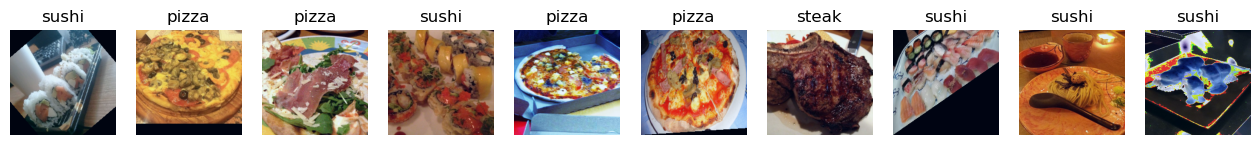

In [27]:
from helper_functions import view_dataloader_images

view_dataloader_images(dataloader=train_dataloader_20_percent_with_aug, class_names=class_names, n=10)

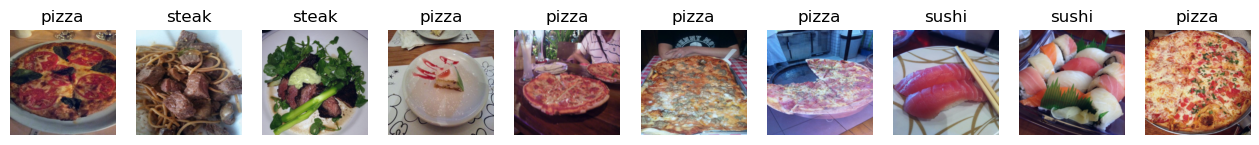

In [28]:
view_dataloader_images(dataloader=train_dataloader_20_percent_without_aug, class_names=class_names, n=10)

In [29]:
# Setup number of epochs
num_epochs = [5, 10]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
                     "data_20_percent_without_aug": train_dataloader_20_percent_without_aug}

# Create model
models = ["effnetb3"]

In [30]:
from going_modular.utils import save_model
from going_modular.engine import train

set_seeds()

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            # create information print out
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs:{epochs}")

            if model_name == "effnetb2":
                model = create_effnetb2()
            else:
                model = create_effnetb3()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            writer = create_writer(experiment_name=dataloader_name,
                                   model_name=model_name, extra=f"{epochs}_epochs")
            print(type(writer))
            train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                  loss_fn=loss_fn, optimizer=optimizer, epochs=epochs, device=device, writer=writer)

            save_filepath = f"07_exercise_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir="models", model_name=save_filepath)
            print("-"*50+"\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs:5
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent_with_aug/effnetb3/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0736 | train_acc: 0.3984 | test_loss: 1.0038 | test_acc: 0.6297


 20%|██        | 1/5 [00:03<00:14,  3.52s/it]

Epoch: 2 | train_loss: 0.9391 | train_acc: 0.6484 | test_loss: 0.8362 | test_acc: 0.8646


 40%|████      | 2/5 [00:07<00:10,  3.65s/it]

Epoch: 3 | train_loss: 0.8242 | train_acc: 0.8008 | test_loss: 0.8022 | test_acc: 0.7642


 60%|██████    | 3/5 [00:10<00:07,  3.63s/it]

Epoch: 4 | train_loss: 0.7487 | train_acc: 0.8398 | test_loss: 0.7176 | test_acc: 0.8456


 80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

Epoch: 5 | train_loss: 0.6913 | train_acc: 0.8555 | test_loss: 0.6378 | test_acc: 0.8655


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_with_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs:10
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent_with_aug/effnetb3/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0736 | train_acc: 0.3984 | test_loss: 1.0038 | test_acc: 0.6297


 10%|█         | 1/10 [00:03<00:33,  3.69s/it]

Epoch: 2 | train_loss: 0.9391 | train_acc: 0.6484 | test_loss: 0.8362 | test_acc: 0.8646


 20%|██        | 2/10 [00:07<00:28,  3.61s/it]

Epoch: 3 | train_loss: 0.8242 | train_acc: 0.8008 | test_loss: 0.8022 | test_acc: 0.7642


 30%|███       | 3/10 [00:10<00:25,  3.67s/it]

Epoch: 4 | train_loss: 0.7487 | train_acc: 0.8398 | test_loss: 0.7176 | test_acc: 0.8456


 40%|████      | 4/10 [00:14<00:21,  3.66s/it]

Epoch: 5 | train_loss: 0.6913 | train_acc: 0.8555 | test_loss: 0.6378 | test_acc: 0.8655


 50%|█████     | 5/10 [00:18<00:18,  3.65s/it]

Epoch: 6 | train_loss: 0.6957 | train_acc: 0.7188 | test_loss: 0.5933 | test_acc: 0.9062


 60%|██████    | 6/10 [00:21<00:14,  3.63s/it]

Epoch: 7 | train_loss: 0.6568 | train_acc: 0.7539 | test_loss: 0.5989 | test_acc: 0.8456


 70%|███████   | 7/10 [00:25<00:10,  3.61s/it]

Epoch: 8 | train_loss: 0.6300 | train_acc: 0.8008 | test_loss: 0.6415 | test_acc: 0.7850


 80%|████████  | 8/10 [00:29<00:07,  3.63s/it]

Epoch: 9 | train_loss: 0.5514 | train_acc: 0.7734 | test_loss: 0.5797 | test_acc: 0.8258


 90%|█████████ | 9/10 [00:32<00:03,  3.68s/it]

Epoch: 10 | train_loss: 0.6155 | train_acc: 0.7578 | test_loss: 0.5677 | test_acc: 0.7850


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_with_aug_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent_without_aug
[INFO] Number of epochs:5
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent_without_aug/effnetb3/5_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0677 | train_acc: 0.3477 | test_loss: 0.9960 | test_acc: 0.6297


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

Epoch: 2 | train_loss: 0.9349 | train_acc: 0.5977 | test_loss: 0.8262 | test_acc: 0.8750


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

Epoch: 3 | train_loss: 0.7829 | train_acc: 0.8438 | test_loss: 0.7980 | test_acc: 0.8144


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

Epoch: 4 | train_loss: 0.6929 | train_acc: 0.8594 | test_loss: 0.7907 | test_acc: 0.7235


 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

Epoch: 5 | train_loss: 0.7219 | train_acc: 0.7305 | test_loss: 0.7229 | test_acc: 0.7538


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_without_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent_without_aug
[INFO] Number of epochs:10
[INFO] Creating effnetb3 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs/2025-06-23/data_20_percent_without_aug/effnetb3/10_epochs...
<class 'torch.utils.tensorboard.writer.SummaryWriter'>


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0677 | train_acc: 0.3477 | test_loss: 0.9960 | test_acc: 0.6297


 10%|█         | 1/10 [00:03<00:32,  3.56s/it]

Epoch: 2 | train_loss: 0.9349 | train_acc: 0.5977 | test_loss: 0.8262 | test_acc: 0.8750


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

Epoch: 3 | train_loss: 0.7829 | train_acc: 0.8438 | test_loss: 0.7980 | test_acc: 0.8144


 30%|███       | 3/10 [00:10<00:24,  3.54s/it]

Epoch: 4 | train_loss: 0.6929 | train_acc: 0.8594 | test_loss: 0.7907 | test_acc: 0.7235


 40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Epoch: 5 | train_loss: 0.7219 | train_acc: 0.7305 | test_loss: 0.7229 | test_acc: 0.7538


 50%|█████     | 5/10 [00:17<00:17,  3.56s/it]

Epoch: 6 | train_loss: 0.6203 | train_acc: 0.9023 | test_loss: 0.6684 | test_acc: 0.7642


 60%|██████    | 6/10 [00:21<00:14,  3.61s/it]

Epoch: 7 | train_loss: 0.6523 | train_acc: 0.7578 | test_loss: 0.6517 | test_acc: 0.7945


 70%|███████   | 7/10 [00:24<00:10,  3.58s/it]

Epoch: 8 | train_loss: 0.5293 | train_acc: 0.8789 | test_loss: 0.5558 | test_acc: 0.8968


 80%|████████  | 8/10 [00:28<00:07,  3.57s/it]

Epoch: 9 | train_loss: 0.4822 | train_acc: 0.8906 | test_loss: 0.5458 | test_acc: 0.9062


 90%|█████████ | 9/10 [00:32<00:03,  3.56s/it]

Epoch: 10 | train_loss: 0.5976 | train_acc: 0.7383 | test_loss: 0.5181 | test_acc: 0.8655


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]

[INFO] Saving model to: models/07_exercise_effnetb3_data_20_percent_without_aug_10_epochs.pth
--------------------------------------------------



## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [31]:
import torch, torchvision
from torchvision import transforms

In [32]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

train_data = torchvision.datasets.Food101(root="data",
                                          split="train",
                                          transform=simple_transform,
                                          download=True)

test_data = torchvision.datasets.Food101(root="data",
                                          split="test",
                                          transform=simple_transform,
                                          download=True)

In [33]:
# create dataloaders

import os

BATCH_SIZE = 32

train_dataloader_big = torch.utils.data.DataLoader(dataset=train_data,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   num_workers=0,
                                                   pin_memory=True)

test_dataloader_big = torch.utils.data.DataLoader(dataset=test_data,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  num_workers=0,
                                                  pin_memory=True)

In [34]:
# create model
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
foodvision_big_model = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)

for param in foodvision_big_model.features.parameters():
    param.requires_grad = False

foodvision_big_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),nn.Linear(in_features=1280, out_features=101)
).to(device)


# summary(model=foodvision_big_model,
#         input_size=(1, 3, 224, 224))


In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=foodvision_big_model.parameters(), lr=0.001)

In [37]:
foodvision_big_results = train(model=foodvision_big_model,
                               train_dataloader=train_dataloader_big,
                               test_dataloader=test_dataloader_big,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               writer=create_writer(experiment_name="food01_all_data",
                                                    model_name="foodvision_big",
                                                    extra=f"{epochs}_epochs"),
                                                    device=device
                            )

[INFO] Created SummaryWriter, saving to: runs/2025-06-23/food01_all_data/foodvision_big/10_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 2.8237 | train_acc: 0.3508 | test_loss: 2.1549 | test_acc: 0.4735


 20%|██        | 1/5 [09:02<36:08, 542.18s/it]

Epoch: 2 | train_loss: 2.3631 | train_acc: 0.4255 | test_loss: 3.0113 | test_acc: 0.4907


 40%|████      | 2/5 [18:08<27:14, 544.80s/it]

Epoch: 3 | train_loss: 2.2903 | train_acc: 0.4401 | test_loss: 1.9866 | test_acc: 0.4996


 60%|██████    | 3/5 [29:16<19:31, 585.66s/it]


KeyboardInterrupt: 